<a href="https://colab.research.google.com/github/JingWang98/Chihuahua-or-Muffin/blob/main/Algorithms_for_massive_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Market Basket Analysis (Algorithms for Massive Data Project)

Author: Jing Wang

A.Y. 2023-2024

In [1]:
!pip install pyspark
import pyspark

from itertools import combinations
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import max
from pyspark.sql.functions import min
from pyspark.sql import functions as F
import heapq
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=c792bd6909e0c00a3f94f232730e6a15737ca7ce0d9c76980ea70a811a5c2e7d
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
# connect to kaggle using credentials
os.environ['KAGGLE_USERNAME'] = 'xxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxx'

# download the dataset
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

# dataset unzip
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip -d data

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 99% 1.86G/1.88G [00:21<00:00, 134MB/s]
100% 1.88G/1.88G [00:21<00:00, 91.7MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: data/job_skills.csv     
  inflating: data/job_summary.csv    
  inflating: data/linkedin_job_postings.csv  


Initialize PySpark session

In [3]:
spark = SparkSession.builder.appName("Apriori").getOrCreate()

In [4]:
df = spark.read.csv("/content/data/job_skills.csv", header = True,sep=",")
df.show()

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
|https://www.linke...|Host/Server Assis...|
|https://www.linke...|Apartment mainten...|
|https://www.linke...|Fiber Optic Cable...|
|https://www.linke...|CT Technologist, ...|
|https://ca.linked...|SAP, DRMIS, Data ...|
|https://www.linke...|Debt and equity o...|
|https://ca.linked...|Biomedical Engine...|
|https://www.linke...|Laboratory Techni...|
|https://www.linke...|Program Managemen...|
|https://www.linke...|Hiring, Tr

In [5]:
df.printSchema() # check for null value

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [6]:
df.describe().show()

+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           "* Maintenance, *...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+



In [7]:
df = df.dropna()
df_skills = df.select('job_skills')
df_skills.show()

+--------------------+
|          job_skills|
+--------------------+
|Building Custodia...|
|Customer service,...|
|Applied Behavior ...|
|Electrical Engine...|
|Electrical Assemb...|
|Access Control, V...|
|Consultation, Sup...|
|Veterinary Recept...|
|Optical Inspectio...|
|HVAC, troubleshoo...|
|Host/Server Assis...|
|Apartment mainten...|
|Fiber Optic Cable...|
|CT Technologist, ...|
|SAP, DRMIS, Data ...|
|Debt and equity o...|
|Biomedical Engine...|
|Laboratory Techni...|
|Program Managemen...|
|Hiring, Training,...|
+--------------------+
only showing top 20 rows



In [8]:
df_with_counts = df_skills.withColumn("counts", F.size(F.split(F.col("job_skills"), ",")))

# Show the result
df_with_counts.show()

+--------------------+------+
|          job_skills|counts|
+--------------------+------+
|Building Custodia...|    14|
|Customer service,...|    19|
|Applied Behavior ...|    20|
|Electrical Engine...|    35|
|Electrical Assemb...|    11|
|Access Control, V...|    19|
|Consultation, Sup...|    29|
|Veterinary Recept...|    22|
|Optical Inspectio...|    17|
|HVAC, troubleshoo...|     9|
|Host/Server Assis...|    29|
|Apartment mainten...|    19|
|Fiber Optic Cable...|    16|
|CT Technologist, ...|    11|
|SAP, DRMIS, Data ...|    19|
|Debt and equity o...|    27|
|Biomedical Engine...|    18|
|Laboratory Techni...|    28|
|Program Managemen...|    23|
|Hiring, Training,...|    33|
+--------------------+------+
only showing top 20 rows



In [41]:
max_count = df_with_counts.select(max('counts')).collect()[0][0]
max_rows = df_with_counts.filter(df_with_counts['counts'] == max_count)
max_rows.show()

+--------------------+------+
|          job_skills|counts|
+--------------------+------+
|Clinical Manageme...|   463|
+--------------------+------+



if each row reresents a job position, i want to see the average number of skills for each job

In [10]:
total_sum = df_with_counts.agg(F.sum("counts").alias("total_sum")).collect()[0]["total_sum"]
num_rows = df.count()
average = total_sum / num_rows
print(f"Average number of skills required by each job: {average}")


Average number of skills required by each job: 20.789084144149992


Sample the data

In [11]:
sample = df_skills.sample(False,0.01,seed=123)
sample.show()
sample.count()

+--------------------+
|          job_skills|
+--------------------+
|Service Mentality...|
|ECE units, Teachi...|
|Quantity Surveyin...|
|CDL B, Truck driv...|
|Accounting, Night...|
|Safety, Quality, ...|
|Food Safety Stand...|
|Refrigeration uni...|
|Skills Frameworks...|
|Military enlistme...|
|Customer service,...|
|Statistical Analy...|
|Clinical Care, Nu...|
|Communication, Cu...|
|Housekeeping, Cus...|
|Financial Analysi...|
|Automotive Servic...|
|ATSM, AAI, Phase ...|
|Administrative As...|
|Tax preparation, ...|
+--------------------+
only showing top 20 rows



12851

In [12]:
rdd = sample.rdd
rdd.first()

Row(job_skills='Service Mentality, Attention to Detail, Sense of Urgency, Initiative, Flexibility, Logic, Problemsolving, Customer service, Tact, Professionalism, HIPAA, PHI, Federal and state laws, Strong service mentality, Telephone etiquette, Personal etiquette, Warm, Positive, Energetic, Professional, Oral communication, Written communication, Tactful communication, Diplomatic communication, Personnel recruitment, Performance management, Performance assessment, Selfdevelopment, Proficient in computer applications, Word, Excel, Coordinating, Prioritizing, Multitasking, Opportunity identification, Plan of action development, Plan implementation, Plan evaluation, Conflict resolution, 401(k) Retirement Plan, Medical Plan, Vision Plan, Prescription Plan, Telehealth Plan, Dental Plan, Life and Disability Insurance, Paid Time Off, Extended Illness Days, Colleague Referral Bonus, Tuition Reimbursement, Commuter Benefits, Dependent Care Spending Account, Employee Discounts')

Retrieve the number of partitions of the RDD

In [13]:
num_partitions = rdd.getNumPartitions()
print(num_partitions)

6


In [14]:
rdd_new = rdd.map(lambda x: x[0])
rdd_new.first()

'Service Mentality, Attention to Detail, Sense of Urgency, Initiative, Flexibility, Logic, Problemsolving, Customer service, Tact, Professionalism, HIPAA, PHI, Federal and state laws, Strong service mentality, Telephone etiquette, Personal etiquette, Warm, Positive, Energetic, Professional, Oral communication, Written communication, Tactful communication, Diplomatic communication, Personnel recruitment, Performance management, Performance assessment, Selfdevelopment, Proficient in computer applications, Word, Excel, Coordinating, Prioritizing, Multitasking, Opportunity identification, Plan of action development, Plan implementation, Plan evaluation, Conflict resolution, 401(k) Retirement Plan, Medical Plan, Vision Plan, Prescription Plan, Telehealth Plan, Dental Plan, Life and Disability Insurance, Paid Time Off, Extended Illness Days, Colleague Referral Bonus, Tuition Reimbursement, Commuter Benefits, Dependent Care Spending Account, Employee Discounts'

In [15]:
baskets = rdd_new.map(lambda line: line.split(', '))
baskets.first()

['Service Mentality',
 'Attention to Detail',
 'Sense of Urgency',
 'Initiative',
 'Flexibility',
 'Logic',
 'Problemsolving',
 'Customer service',
 'Tact',
 'Professionalism',
 'HIPAA',
 'PHI',
 'Federal and state laws',
 'Strong service mentality',
 'Telephone etiquette',
 'Personal etiquette',
 'Warm',
 'Positive',
 'Energetic',
 'Professional',
 'Oral communication',
 'Written communication',
 'Tactful communication',
 'Diplomatic communication',
 'Personnel recruitment',
 'Performance management',
 'Performance assessment',
 'Selfdevelopment',
 'Proficient in computer applications',
 'Word',
 'Excel',
 'Coordinating',
 'Prioritizing',
 'Multitasking',
 'Opportunity identification',
 'Plan of action development',
 'Plan implementation',
 'Plan evaluation',
 'Conflict resolution',
 '401(k) Retirement Plan',
 'Medical Plan',
 'Vision Plan',
 'Prescription Plan',
 'Telehealth Plan',
 'Dental Plan',
 'Life and Disability Insurance',
 'Paid Time Off',
 'Extended Illness Days',
 'Colleag

In [16]:
# Flatten the RDD
RDD_F = baskets.flatMap(lambda line: line)

RDD_F.first()

'Service Mentality'

In [17]:
# Count the total number of elements in the flattened RDD
check_n_skills = RDD_F.count()

print(f"Total number of items: {check_n_skills}")

Total number of items: 267561


In [18]:
# Remove duplicate items
RDD_F = RDD_F.distinct()

# Count the total number of unique items
U_skills = RDD_F.count()

print(f"Total number of unique items: {U_skills}")

Total number of unique items: 99082


Pair each element of the hash RDD with a unique index

In [19]:
RDD_F = RDD_F.zipWithIndex()
RDD_F.take(8)

[('Attention to Detail', 0),
 ('Logic', 1),
 ('Professionalism', 2),
 ('Professional', 3),
 ('Proficient in computer applications', 4),
 ('Excel', 5),
 ('Conflict resolution', 6),
 ('401(k) Retirement Plan', 7)]

In [20]:
RDD_F_index = RDD_F.collectAsMap() # transforms an hash RDD of key-value pairs into a Python dictionary.
RDD_F_index

{'Attention to Detail': 0,
 'Logic': 1,
 'Professionalism': 2,
 'Professional': 3,
 'Proficient in computer applications': 4,
 'Excel': 5,
 'Conflict resolution': 6,
 '401(k) Retirement Plan': 7,
 'Employee Discounts': 8,
 'Project Management': 9,
 'BlueBeam CAD': 10,
 'Primavera': 11,
 'AutoCAD': 12,
 'Preemployment substance abuse screening': 13,
 'Background check': 14,
 'Night Auditing': 15,
 'EEOC': 16,
 'Contract negotiation': 17,
 '3+ years field supervision experience': 18,
 'Dental benefits': 19,
 'Equal opportunity employer': 20,
 'Microsoft Office': 21,
 'Physical Stamina': 22,
 'Cleaning': 23,
 'Shop tools': 24,
 'Ability to work in nonclimate controlled environments': 25,
 'Attention to detail': 26,
 'Ability to follow safety regulations': 27,
 'ASE Certification': 28,
 'High school diploma or equivalent': 29,
 'Ability to work flexible hours': 30,
 'Army National Guard': 31,
 'Shipping and receiving': 32,
 'Storage and distribution': 33,
 'Warehouse management': 34,
 'For

In [21]:
#transforming baskets into sets
def sets(basket):
    return {RDD_F_index[skill] for skill in basket}

baskets = baskets.map(sets)

In [22]:
type(baskets)

pyspark.rdd.PipelinedRDD

In [23]:
baskets.first()

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 16642,
 16643,
 16644,
 16645,
 16646,
 16647,
 16648,
 16649,
 33030,
 33031,
 33032,
 33033,
 33034,
 33035,
 33036,
 33037,
 33038,
 33039,
 49416,
 49417,
 49418,
 49419,
 49420,
 49421,
 49422,
 49423,
 49424,
 65891,
 65892,
 65893,
 65894,
 65895,
 65896,
 65897,
 65898,
 65899,
 65900,
 82566,
 82567,
 82568,
 82569,
 82570,
 82571,
 82572}

The A-Priori Algorithm

In [24]:
support = 300
first_pass = baskets.flatMap(lambda basket:[(skill,1) for skill in basket]) \
                .reduceByKey(lambda x,y:x+y) \
                .filter(lambda x:x[1]>support)

print("Number of frequent singletons:", first_pass.count())


Number of frequent singletons: 61


In [25]:
  max_s = first_pass.max(lambda x: x[1])
  max_singleton = (list(RDD_F_index.keys())[list(RDD_F_index.values()).index(max_s[0])])
  print("The most frequent singleton is:",max_singleton)

The most frequent singleton is: Communication


In [26]:
top_5_skills = first_pass.takeOrdered(5, key=lambda x: -x[1])

SKILL_1 = []
COUNT_1 = []

print("Top 5 frequent singletons:")
for singleton in top_5_skills:
    skill_index, count = singleton
    # Find the key corresponding to the given value
    keys_for_value = [key for key, value in RDD_F_index.items() if value == skill_index]
    SKILL_1.append(keys_for_value)
    COUNT_1.append(count)
    print(f"Skill_index: {skill_index}, Count: {count}")
    print(f"Key corresponding to the value {skill_index}: {keys_for_value}")

Top 5 frequent singletons:
Skill_index: 82585, Count: 3605
Key corresponding to the value 82585: ['Communication']
Skill_index: 65911, Count: 2220
Key corresponding to the value 65911: ['Teamwork']
Skill_index: 82608, Count: 1826
Key corresponding to the value 82608: ['Leadership']
Skill_index: 82568, Count: 1588
Key corresponding to the value 82568: ['Customer service']
Skill_index: 49450, Count: 1118
Key corresponding to the value 49450: ['Communication skills']


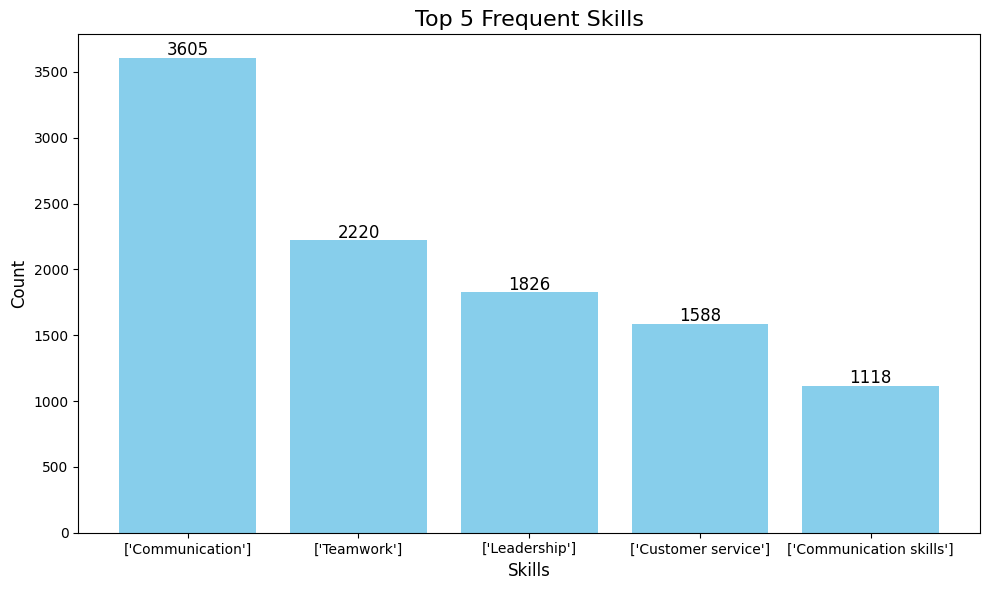

In [27]:
plt.figure(figsize=(10, 6))
SKILL_1 = [str(skill) for skill in SKILL_1]
bars = plt.bar(SKILL_1, COUNT_1, color='skyblue')

# Add titles and labels
plt.title('Top 5 Frequent Skills', fontsize=16)
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Add counts on top of the bars
for bar, count in zip(bars, COUNT_1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 10,
             str(count),
             ha='center', va='bottom', fontsize=12, color='black')

plt.xticks()
plt.tight_layout()
plt.show()

In [28]:
frequent_singletons = set(first_pass.map(lambda x:x[0]).collect())
second_pass = baskets.flatMap(lambda basket:[(skill,1) for skill in combinations(sorted(basket),2)]) \
                 .filter(lambda x: x[0][0] in frequent_singletons) \
                 .filter(lambda x: x[0][1] in frequent_singletons) \
                 .reduceByKey(lambda x,y: x+y) \
                 .filter(lambda x:x[1]>support)
print(second_pass.count())

33


In [29]:
max_p = second_pass.max(lambda x: x[1])
max_pair = []
for skill in max_p[0]:
  max_pair.append(list(RDD_F_index.keys())[list(RDD_F_index.values()).index(skill)])
print("The most frequent pair of skills are", max_pair)

The most frequent pair of skills are ['Teamwork', 'Communication']


In [31]:
top_5_skills_pairs = second_pass.takeOrdered(5, key=lambda x: -x[1])
print("Top 5 frequent skills pairs:")
for pair in top_5_skills_pairs:
    skills_index, count = pair
    # Convert skill indexes to skill names
    keys_for_value = [key for key, value in RDD_F_index.items() if value == skills_index]
    print(f"Skills Pair: {skills_index}, Count: {count}")

Top 5 frequent skills pairs:
Skills Pair: (65911, 82585), Count: 1364
Skills Pair: (82585, 82608), Count: 1161
Skills Pair: (82568, 82585), Count: 776
Skills Pair: (33030, 82585), Count: 672
Skills Pair: (65911, 82608), Count: 658


In [32]:
SKILL_2 = []
COUNT_2 = []

print("Top 5 frequent skills pairs:")
for pair in top_5_skills_pairs:
    skills_index, count = pair
    skill_names =[]
    for skill_index in skills_index:
    # Find the key corresponding to the given value
        skill_names += [key for key, value in RDD_F_index.items() if value == skill_index]
    SKILL_2.append(skill_names)
    COUNT_2.append(count)
    print(f"Skills: {skill_names}, Count: {count}")

Top 5 frequent skills pairs:
Skills: ['Teamwork', 'Communication'], Count: 1364
Skills: ['Communication', 'Leadership'], Count: 1161
Skills: ['Customer service', 'Communication'], Count: 776
Skills: ['Problemsolving', 'Communication'], Count: 672
Skills: ['Teamwork', 'Leadership'], Count: 658


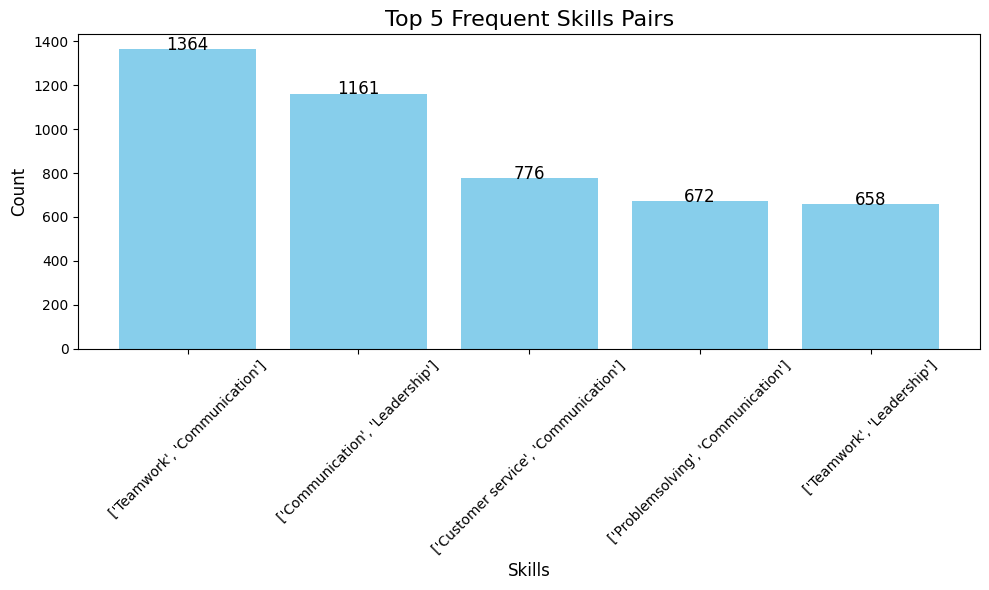

In [33]:
plt.figure(figsize=(10, 6))
SKILL_2 = [str(skill) for skill in SKILL_2]
bars_2 = plt.bar(SKILL_2, COUNT_2, color='skyblue')

plt.title('Top 5 Frequent Skills Pairs', fontsize=16)
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Add counts on top of the bars
for bar, count in zip(bars_2, COUNT_2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 20,
             str(count),
             ha='center', va='bottom', fontsize=12, color='black')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
frequent_pairs = set(second_pass.map(lambda x:x[0]).collect())
third_pass = baskets.flatMap(lambda basket:[(skill,1) for skill in combinations(sorted(basket),3)]) \
                 .filter(lambda x: (x[0][0],x[0][1]) in frequent_pairs) \
                 .filter(lambda x: (x[0][1],x[0][2]) in frequent_pairs) \
                 .filter(lambda x: (x[0][0],x[0][2]) in frequent_pairs) \
                 .reduceByKey(lambda x,y: x+y) \
                 .filter(lambda x:x[1]>support)
print(third_pass.count())

4


In [82]:
max_t = third_pass.max(lambda x: x[1])
max_triple = []
for skill in max_t[0]:
  max_triple.append(list(RDD_F_index.keys())[list(RDD_F_index.values()).index(skill)])
print("The most frequent triple skills are", max_triple)

The most frequent triple skills are ['Teamwork', 'Communication', 'Leadership']


In [83]:
top_4_skills_triplets = third_pass.takeOrdered(4, key=lambda x: -x[1])

In [84]:
print("Top 4 frequent skills triplets:")
for triple in top_4_skills_triplets:
    skills_index, count = triple
    # Convert skill indexes to skill names
    keys_for_value = [key for key, value in RDD_F_index.items() if value == skills_index]
    print(f"Skills Triplets: {skills_index}, Count: {count}")

Top 4 frequent skills triplets:
Skills Triplets: (65911, 82585, 82608), Count: 510
Skills Triplets: (33030, 65911, 82585), Count: 402
Skills Triplets: (65911, 82568, 82585), Count: 380
Skills Triplets: (33030, 82568, 82585), Count: 321


In [85]:
SKILL_3 = []
COUNT_3 = []
print("Top 4 frequent skills triplets:")
for triple in top_4_skills_triplets:
    skills_index, count = triple
    skill_names_trip =[]
    for skill_index in skills_index:
    # Find the key corresponding to the given value
        skill_names_trip += [key for key, value in RDD_F_index.items() if value == skill_index]
    SKILL_3.append(skill_names_trip)
    COUNT_3.append(count)
    print(f"Skills: {skill_names_trip}, Count: {count}")

Top 4 frequent skills triplets:
Skills: ['Teamwork', 'Communication', 'Leadership'], Count: 510
Skills: ['Problemsolving', 'Teamwork', 'Communication'], Count: 402
Skills: ['Teamwork', 'Customer service', 'Communication'], Count: 380
Skills: ['Problemsolving', 'Customer service', 'Communication'], Count: 321


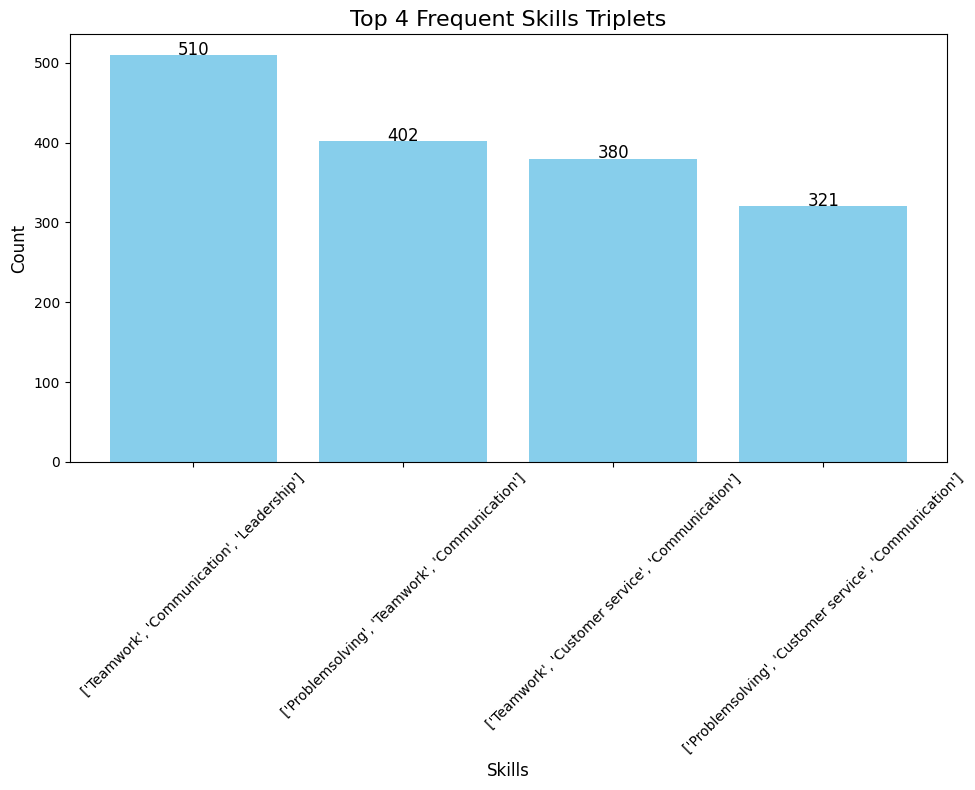

In [81]:
plt.figure(figsize=(10, 8))
SKILL_3 = [str(skill) for skill in SKILL_3]
bars_3 = plt.bar(SKILL_3, COUNT_3, color='skyblue')

plt.title('Top 4 Frequent Skills Triplets', fontsize=16)
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Add counts on top of the bars
for bar, count in zip(bars_3, COUNT_3):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,
             str(count),
             ha='center', va='bottom', fontsize=12, color='black')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Define a function called apriori()

In [78]:
def apriori(baskets_collection,support,RDD_F_index):

  print("Frequent singletons")

  first_pass = baskets_collection.flatMap(lambda basket: [(skill,1) for skill in basket]) \
                                .reduceByKey(lambda x,y: x+y) \
                                .filter(lambda x: x[1]>support)

  first_pass_count = first_pass.count()

  if first_pass_count == 0:
    print("Lower the support")
    return

  print("Number of frequent singletons:",first_pass_count)

  max_s = first_pass.max(lambda x: x[1])
  max_singleton = (list(RDD_F_index.keys())[list(RDD_F_index.values()).index(max_s[0])])
  print("Most frequent singleton:",max_singleton)

  counts = set(first_pass.map(lambda x: (x[0],)).collect())

  print()

  k = 2

  while True:

    print("Itemesets of size:",k)

    pass_n = baskets_collection.flatMap(lambda basket:[(skill,1) for skill in combinations(sorted(basket),k) if
                                                      all(item in counts for item in combinations(skill,k-1))]) \
                              .reduceByKey(lambda x,y: x+y) \
                              .filter(lambda x: x[1]>support)

    pass_count = pass_n.count()

    if pass_count != 0:
      print("Number of frequent itemsets of size",k,"are:",pass_count)

      max_p = pass_n.max(lambda x: x[1])
      max_itemset = []
      for skill in max_p[0]:
        max_itemset.append(list(RDD_F_index.keys())[list(RDD_F_index.values()).index(skill)])
      print("Most frequent itemset of size",k,"is composed by:",max_itemset)

      counts = set(pass_n.map(lambda x: x[0]).collect())

      print()

      k+=1

    else:
      print("There are no frequent itemsets of size",k)

      break

In [79]:
apriori(baskets,support,RDD_F_index)

Frequent singletons
Number of frequent singletons: 61
Most frequent singleton: Communication

Itemesets of size: 2
Number of frequent itemsets of size 2 are: 33
Most frequent itemset of size 2 is composed by: ['Teamwork', 'Communication']

Itemesets of size: 3
Number of frequent itemsets of size 3 are: 4
Most frequent itemset of size 3 is composed by: ['Teamwork', 'Communication', 'Leadership']

Itemesets of size: 4
There are no frequent itemsets of size 4


In [80]:
spark.stop


<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x7ced9f7fe5f0>>